In [31]:
import pandas as pd

import pymc3 as pm

import matplotlib.pyplot as plt

import arviz as az

In [29]:
df = pd.read_csv(r'data.csv')
print(df)

     Unnamed: 0  ppvt  educ_cat  momage
0             1   120         2      21
1             2    89         1      17
2             3    78         2      19
3             4    42         1      20
4             5   115         4      26
..          ...   ...       ...     ...
395         396    87         3      21
396         397    69         2      20
397         398    80         1      25
398         399    98         1      18
399         400    81         2      22

[400 rows x 4 columns]


In [108]:
df['ppvt'].std()

20.440093868261908

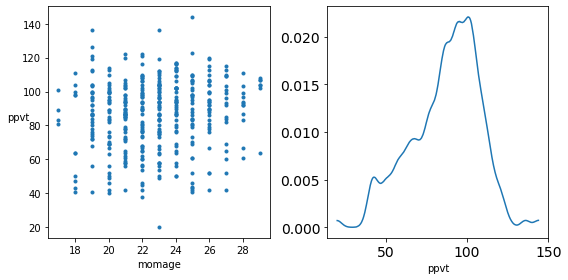

In [70]:
_, ax = plt.subplots(1, 2, figsize=(8, 4))
ax[0].plot(df['momage'], df['ppvt'], 'C0.')
ax[0].set_xlabel('momage')
ax[0].set_ylabel('ppvt', rotation=0)
az.plot_kde(df['ppvt'], ax=ax[1])
ax[1].set_xlabel('ppvt')
plt.tight_layout()

In [101]:
df_stand = df[['ppvt', 'educ_cat', 'momage']]
df_stand = (df_stand-df_stand.mean())/df_stand.std()
print(df_stand)

         ppvt  educ_cat    momage
0    1.617776 -0.138321 -0.665525
1    0.101149 -1.367842 -2.152731
2   -0.437009 -0.138321 -1.409128
3   -2.198253 -1.367842 -1.037326
4    1.373159  2.320721  1.193483
..        ...       ...       ...
395  0.003302  1.091200 -0.665525
396 -0.877320 -0.138321 -1.037326
397 -0.339162 -1.367842  0.821681
398  0.541460 -1.367842 -1.780929
399 -0.290238 -0.138321 -0.293723

[400 rows x 3 columns]


In [131]:
with pm.Model() as model_g:
    α = pm.Normal('α', mu=df['ppvt'].mean(), sd=10*df['ppvt'].std())
    β = pm.Normal('β', mu=0, sd=1)
    ε = pm.HalfCauchy('ε', 7)
    μ = pm.Deterministic('μ', α + β * df['momage'])
    y_pred = pm.Normal('y_pred', mu=μ, sd=ε, observed=df['ppvt'])
    idata_g = pm.sample(2000, tune=6000, return_inferencedata=True)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [ε, β, α]


Sampling 4 chains for 6_000 tune and 2_000 draw iterations (24_000 + 8_000 draws total) took 36 seconds.
There were 195 divergences after tuning. Increase `target_accept` or reparameterize.
The acceptance probability does not match the target. It is 0.5390226051135201, but should be close to 0.8. Try to increase the number of tuning steps.
The number of effective samples is smaller than 10% for some parameters.


array([[<AxesSubplot:title={'center':'α'}>,
        <AxesSubplot:title={'center':'α'}>],
       [<AxesSubplot:title={'center':'β'}>,
        <AxesSubplot:title={'center':'β'}>],
       [<AxesSubplot:title={'center':'ε'}>,
        <AxesSubplot:title={'center':'ε'}>]], dtype=object)

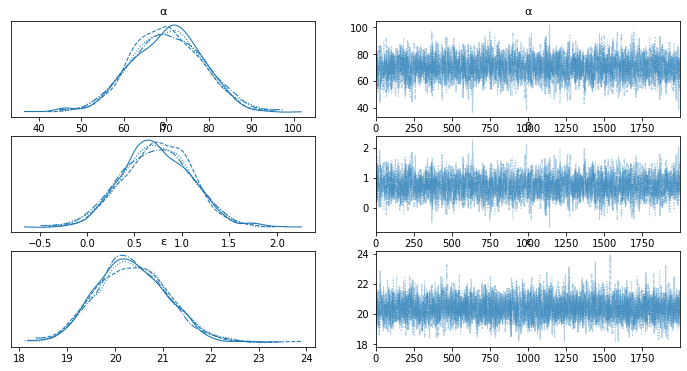

In [121]:
az.plot_trace(idata_g, var_names=['α', 'β', 'ε'])

/home/ina/.local/lib/python3.9/site-packages/pymc3/sampling.py:1708: UserWarning: samples parameter is smaller than nchains times ndraws, some draws and/or chains may not be represented in the returned posterior predictive sample
  warnings.warn(


/home/ina/.local/lib/python3.9/site-packages/arviz/plots/hdiplot.py:157: FutureWarning: hdi currently interprets 2d data as (draw, shape) but this will change in a future release to (chain, draw) for coherence with other functions
  hdi_data = hdi(y, hdi_prob=hdi_prob, circular=circular, multimodal=False, **hdi_kwargs)


Text(0, 0.5, 'ppvt')

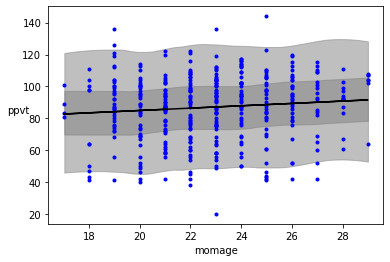

In [122]:
posterior_g = idata_g.posterior.stack(samples={"chain", "draw"})
alpha_m = posterior_g['α'].mean().item()
beta_m = posterior_g['β'].mean().item()
draws = range(0, posterior_g.samples.size, 10)

ppc = pm.sample_posterior_predictive(idata_g, samples=2000, model=model_g)
plt.plot(df['momage'], df['ppvt'], 'b.')
plt.plot(df['momage'], alpha_m + beta_m * df['momage'], c='k',
label=f"y = {alpha_m:.2f} + {beta_m:.2f} * df['momage']")
az.plot_hdi(df['momage'], ppc['y_pred'], hdi_prob=0.5, color='gray')
az.plot_hdi(df['momage'], ppc['y_pred'], color='gray')
plt.xlabel('momage')
plt.ylabel('ppvt', rotation=0)

In [ ]:
# dupa cum putea vedea, varsta influenteaza foarte putin IQ-ul copilului,
# dar daca se doreste o mica crestere a probabilitatii de a avea un IQ mai bun, 
# varsta mai mare da asta